# Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error

# Load Dataset

In [10]:
df = pd.read_csv('BTC-USD.csv')
df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
df

,Date,Open,High,Low,Close,Volume
0,2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...,...
3829,2025-03-12 00:00:00+00:00,82857.375000,84358.578125,80635.250000,83722.359375,40353484454
3830,2025-03-13 00:00:00+00:00,83724.921875,84301.695312,79931.851562,81066.703125,31412940153
3831,2025-03-14 00:00:00+00:00,81066.992188,85263.289062,80797.562500,83969.101562,29588112414
3832,2025-03-15 00:00:00+00:00,83968.406250,84672.671875,83639.593750,84343.109375,13650491277


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3834 non-null   object 
 1   Open    3834 non-null   float64
 2   High    3834 non-null   float64
 3   Low     3834 non-null   float64
 4   Close   3834 non-null   float64
 5   Volume  3834 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 179.8+ KB


In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Bitcoin Price Candlestick Chart Visualization

In [15]:
fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    increasing_line_color='green',
    decreasing_line_color='red',
    hovertext=df.index.strftime('%d %b %Y') + '<br>Open: ' + df['Open'].astype(str) +
              '<br>High: ' + df['High'].astype(str) + '<br>Low: ' + df['Low'].astype(str) +
              '<br>Close: ' + df['Close'].astype(str),
    hoverinfo='text'
)])

fig.update_layout(
    title="Bitcoin Price Candlestick Chart",
    xaxis_title="Date & Year",
    yaxis_title="Price (USD)",
    xaxis_rangeslider_visible=False,
    xaxis=dict(
        tickformat="%Y",
        dtick="M12"
    ),
    yaxis=dict(
        tick0=0,
        dtick=10000
    ),
    width=900,
    height=450
)

fig.show()


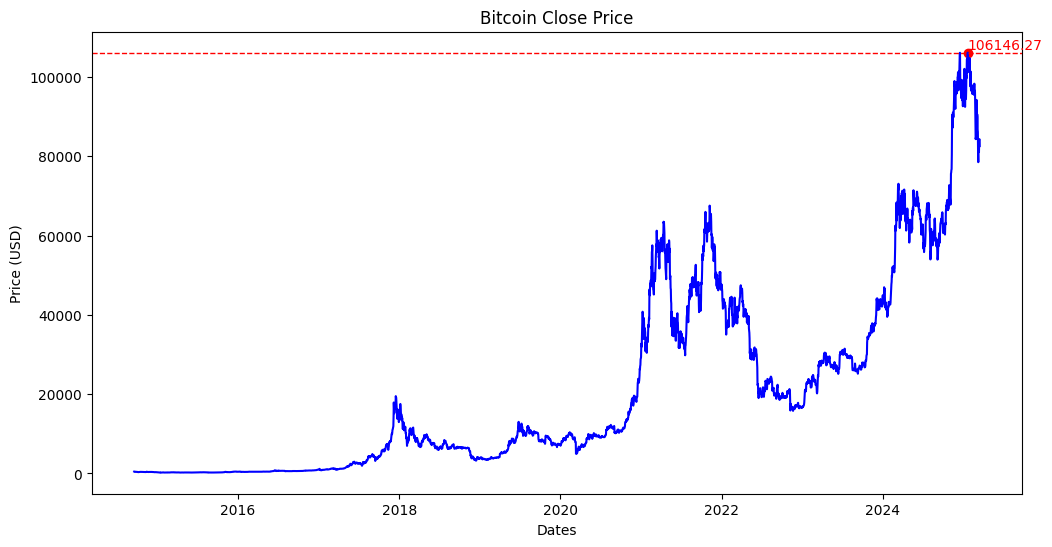

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df['Close'], color='blue', linewidth=1.5)

ath_price = df['Close'].max()
ath_date = df['Close'].idxmax()

plt.axhline(y=ath_price, color='red', linestyle='--', linewidth=1)
plt.scatter(ath_date, ath_price, color='red')

plt.text(ath_date, ath_price, f'{ath_price:.2f}', color='red', fontsize=10, verticalalignment='bottom')

plt.title('Bitcoin Close Price')
plt.xlabel('Dates')
plt.ylabel('Price (USD)')

plt.show()


# Preprocessing

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

In [17]:
data_scaled

array([[0.00263505],
       [0.00232463],
       [0.00204489],
       ...,
       [0.79071861],
       [0.79424805],
       [0.77760699]])

In [18]:
def create_sequences(df, seq_length):
    sequences, labels = [], []
    for i in range(len(df) - seq_length):
        sequences.append(df[i:i + seq_length])
        labels.append(df[i + seq_length, 0])
    return np.array(sequences), np.array(labels)

In [19]:
seq_length = 30

train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Training using LSTM

In [20]:
model = Sequential()

# First Layer LSTM
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second Layer LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense Layer
model.add(Dense(units=25))
model.add(Dense(units=1))

In [45]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=200, batch_size=84, validation_data=(X_test, y_test))

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 3.5044e-04 - val_loss: 3.6982e-04
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 2.4627e-04 - val_loss: 5.5666e-04
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 2.5288e-04 - val_loss: 3.7387e-04
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 2.9086e-04 - val_loss: 4.7537e-04
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 2.4365e-04 - val_loss: 2.9485e-04
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.6785e-04 - val_loss: 3.4818e-04
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 2.7846e-04 - val_loss: 5.7422e-04
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 2.5581e-04 - val_loss: 3.2663e-04
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.9184e-04 - val_loss: 8.5898e-04
Epoch 10/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 2.9305e-04 - val_loss: 0.0010
Epoch 11/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 2.

# Model Evaluation

In [46]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_scaled, predictions)
print('Mean Squared Error:', mse)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Mean Squared Error: 3134368.2701787804


In [47]:
mape = np.mean(np.abs((y_test_scaled - predictions) / y_test_scaled)) * 100
print('Mean Absolute Percentage Error (MAPE):', mape, '%')

Mean Absolute Percentage Error (MAPE): 2.1567098462026424 %


# Actual Price vs Predicted Price

In [48]:
last_day = df['Close'][-seq_length:].values.reshape(-1, 1)
last_day_scaled = scaler.transform(last_day)

X_predict = []
X_predict.append(last_day_scaled)
X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

predicted_price = model.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price)

print('Predicted Price:', predicted_price[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Price: 81973.84


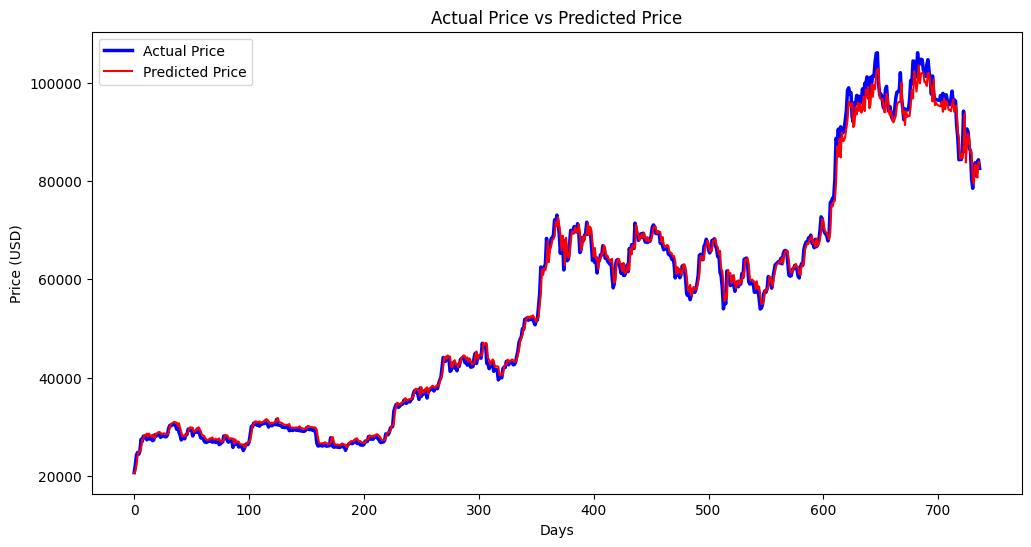

In [49]:
plt.figure(figsize=(12, 6))

plt.plot(y_test_scaled, label='Actual Price', color='blue', linewidth=2.5)
plt.plot(predictions, label='Predicted Price', color='red', linewidth=1.5)

plt.title('Actual Price vs Predicted Price')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()

plt.show()

# Future Price Predictions

In [50]:
future_days = 30

last_seq_days = df['Close'][-seq_length:].values.reshape(-1, 1)
last_seq_days_scaled = scaler.transform(last_seq_days)
future_predictions = []

for i in range(future_days):
    X_predict = []
    X_predict.append(last_seq_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)

    future_predictions.append(predicted_price_unscaled[0][0])

    new_data_scaled = np.append(last_seq_days_scaled[1:], predicted_price, axis=0)
    last_seq_days_scaled = new_data_scaled.reshape(-1, 1)

future_dates = pd.date_range(start=df.index[-1], periods=future_days + 1, freq='D')[1:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

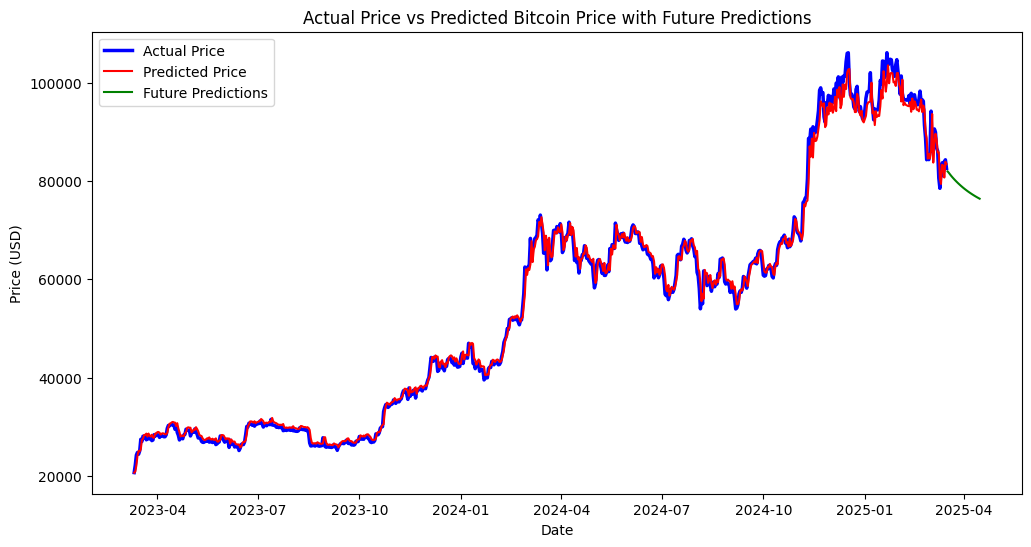

In [51]:
plt.figure(figsize=(12, 6))

plt.plot(df.index[-len(y_test_scaled):], y_test_scaled, label='Actual Price', color='blue', linewidth=2.5)
plt.plot(df.index[-len(y_test_scaled):], predictions, label='Predicted Price', color='red', linewidth=1.5)
plt.plot(future_dates, future_predictions, label='Future Predictions', color='green', linewidth=1.5)

plt.title('Actual Price vs Predicted Bitcoin Price with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

plt.show()

In [52]:
future_predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_predictions})
future_predictions_df

,Date,Predicted Price
0,2025-03-17 00:00:00+00:00,81973.843750
1,2025-03-18 00:00:00+00:00,81713.312500
2,2025-03-19 00:00:00+00:00,81420.351562
3,2025-03-20 00:00:00+00:00,81134.101562
4,2025-03-21 00:00:00+00:00,80866.296875
5,2025-03-22 00:00:00+00:00,80611.031250
6,2025-03-23 00:00:00+00:00,80365.273438
7,2025-03-24 00:00:00+00:00,80127.867188
8,2025-03-25 00:00:00+00:00,79898.468750
9,2025-03-26 00:00:00+00:00,79676.750000
